## **ENDG 511 Final Projet: Concrete Crack Detection**









# Imports

In [ ]:
import torch
import pandas as pd
import zipfile
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
from random import sample
from scipy.io import loadmat
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import seaborn as sns
from torchvision import transforms
from sklearn.metrics import confusion_matrix
import torch.nn as nn
import torchvision.models as models
import time
from sklearn.metrics import accuracy_score
from collections import defaultdict, Counter
from matplotlib.animation import FuncAnimation, PillowWriter
from io import BytesIO
import torch.nn.utils.prune as prune
import copy
import torch.nn.functional as F
import random
import shutil
import torch.optim as optim
import torch.quantization
import gc
from torch.quantization import prepare, convert, get_default_qconfig, fuse_modules
from torchvision.datasets import ImageFolder

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Visualizing Crack Dataset

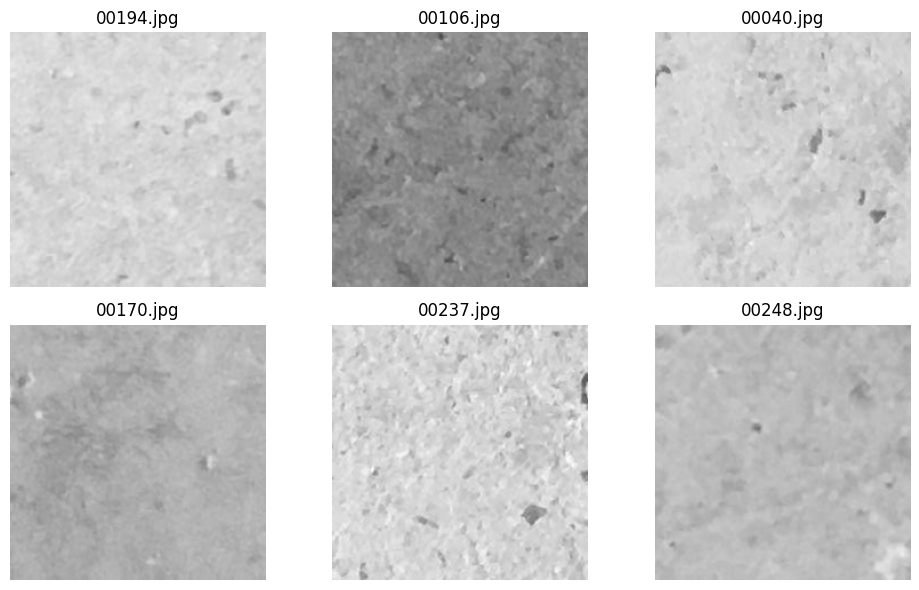

In [ ]:
non_crack_dataset = Path ("/content/drive/My Drive/511 Project/datasets/cracking/Negative/")

# List all spectrogram files in the directory

non_crack_filenames = os.listdir(non_crack_dataset)

# Number of spectrogram samples to visualize
num_samples = 6
# Randomly select 'num_samples' spectrogram files from the dataset
selected_files = sample(non_crack_filenames, num_samples)

# Create a 2x3 grid for visualization
fig, axes = plt.subplots(2, 3, figsize=(10, 6), sharex=True, sharey=True)

# Iterate through selected files and plot spectrograms
for i, ax in enumerate(axes.ravel()):
    # Load spectrogram image
    non_crack_path = os.path.join(non_crack_dataset, selected_files[i])
    non_crack = np.array(Image.open(non_crack_path).convert("L").resize((224, 224))).T
    # Ensure the spectrogram has correct dimensions
    non_crack = np.squeeze(non_crack)

    # Display the spectrogram
    ax.imshow(non_crack, cmap='gray', vmin=0, vmax=255)  # Ensuring a grayscale colormap
    ax.set_title(selected_files[i].split('_')[0])  # Extract class label from filename
    ax.axis("off")  # Hide axes for better visualization

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

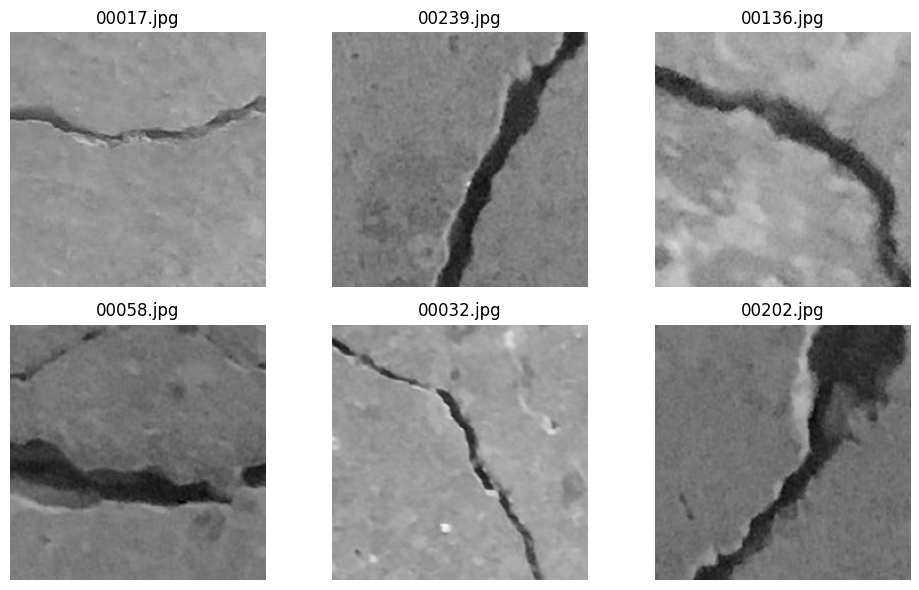

In [ ]:
crack_dataset = Path ("/content/drive/MyDrive/511 Project/datasets/cracking/Positive")

# List all spectrogram files in the directory

crack_filenames = os.listdir(crack_dataset)

# Number of spectrogram samples to visualize
num_samples = 6
# Randomly select 'num_samples' spectrogram files from the dataset
selected_files = sample(crack_filenames, num_samples)

# Create a 2x3 grid for visualization
fig, axes = plt.subplots(2, 3, figsize=(10, 6), sharex=True, sharey=True)

# Iterate through selected files and plot spectrograms
for i, ax in enumerate(axes.ravel()):
    # Load spectrogram image
    crack_path = os.path.join(crack_dataset, selected_files[i])
    crack = np.array(Image.open(crack_path).convert("L").resize((224, 224))).T
    # Ensure the spectrogram has correct dimensions
    crack = np.squeeze(crack)

    # Display the spectrogram
    ax.imshow(crack, cmap='gray', vmin=0, vmax=255)  # Ensuring a grayscale colormap
    ax.set_title(selected_files[i].split('_')[0])  # Extract class label from filename
    ax.axis("off")  # Hide axes for better visualization

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

#Visulizing Homemade Dataset

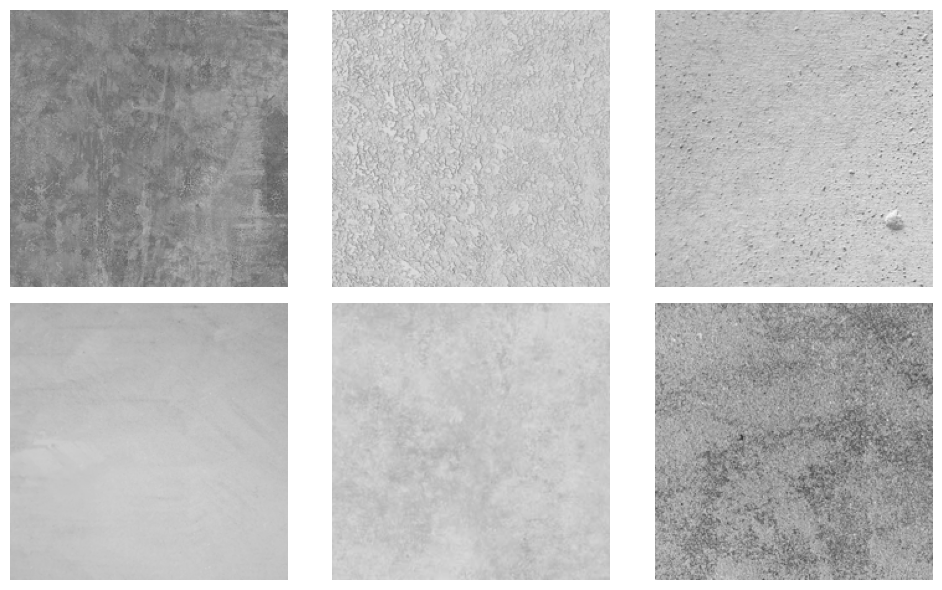

In [ ]:
non_crack_dataset = Path ("/content/drive/My Drive/511 Project/datasets/Homemade/Negative/")

# List all spectrogram files in the directory

non_crack_filenames = os.listdir(non_crack_dataset)

# Number of spectrogram samples to visualize
num_samples = 6
# Randomly select 'num_samples' spectrogram files from the dataset
selected_files = sample(non_crack_filenames, num_samples)

# Create a 2x3 grid for visualization
fig, axes = plt.subplots(2, 3, figsize=(10, 6), sharex=True, sharey=True)

# Iterate through selected files and plot spectrograms
for i, ax in enumerate(axes.ravel()):
    # Load spectrogram image
    non_crack_path = os.path.join(non_crack_dataset, selected_files[i])
    non_crack = np.array(Image.open(non_crack_path).convert("L").resize((224, 224))).T
    # Ensure the spectrogram has correct dimensions
    non_crack = np.squeeze(non_crack)

    # Display the spectrogram
    ax.imshow(non_crack, cmap='gray', vmin=0, vmax=255)  # Ensuring a grayscale colormap
    #ax.set_title(selected_files[i].split('_')[0])  # Extract class label from filename
    ax.axis("off")  # Hide axes for better visualization

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

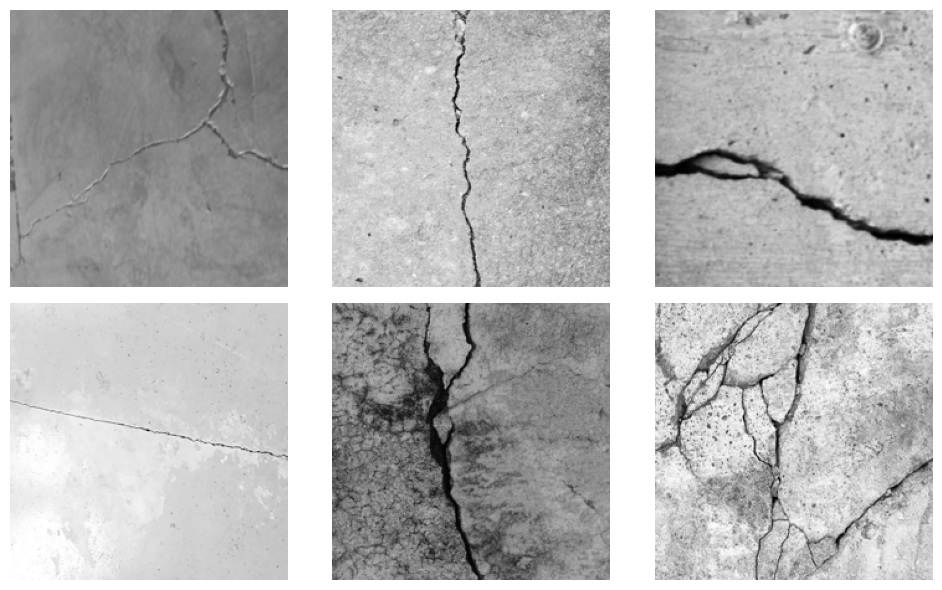

In [ ]:
non_crack_dataset = Path ("/content/drive/My Drive/511 Project/datasets/Homemade/Positive/")

# List all spectrogram files in the directory

non_crack_filenames = os.listdir(non_crack_dataset)

# Number of spectrogram samples to visualize
num_samples = 6
# Randomly select 'num_samples' spectrogram files from the dataset
selected_files = sample(non_crack_filenames, num_samples)

# Create a 2x3 grid for visualization
fig, axes = plt.subplots(2, 3, figsize=(10, 6), sharex=True, sharey=True)

# Iterate through selected files and plot spectrograms
for i, ax in enumerate(axes.ravel()):
    # Load spectrogram image
    non_crack_path = os.path.join(non_crack_dataset, selected_files[i])
    non_crack = np.array(Image.open(non_crack_path).convert("L").resize((224, 224))).T
    # Ensure the spectrogram has correct dimensions
    non_crack = np.squeeze(non_crack)

    # Display the spectrogram
    ax.imshow(non_crack, cmap='gray', vmin=0, vmax=255)  # Ensuring a grayscale colormap
    #ax.set_title(selected_files[i].split('_')[0])  # Extract class label from filename
    ax.axis("off")  # Hide axes for better visualization

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

# Loading Data and Preprocessing


In [ ]:

# Define transformations/augmentations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.Resize((224, 224)),  # Resize images
    transforms.RandomRotation(20),  # Rotate images by ±20 degrees
    transforms.RandomHorizontalFlip(p=0.5),  # Flip 50% of the time
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Random zoom
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load dataset
dataset_path = "/content/drive/MyDrive/511 Project/datasets/cracking"
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Split dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Data Loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Loading Model (ResNet)


In [ ]:
#Model Selection and Building Using Transfer Learning

# ResNet model
model = models.resnet18(pretrained=True)

# Modify first layer to accept grayscale images (1-channel input)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Modify last layer to match binary classification (crack vs. non-crack)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # 2 classes (Crack, No Crack)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()

#adding weight decay to prevent over-reliance on particular features
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 35.0MB/s]


In [ ]:
from torchsummary import summary

# Provide a dummy input size: (1 channel, 224x224 image) for grayscale
summary(model, input_size=(1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           3,136
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

#Freezing Layers

In [ ]:
# Freeze all layers except the final classification layers
for param in model.parameters():
    param.requires_grad = False  # Freeze all layers

# Unfreeze the last few layers (e.g., layer4 and fc)
for param in model.layer4.parameters():
    param.requires_grad = True  # Fine-tune last residual block

for param in model.fc.parameters():
    param.requires_grad = True  # Fine-tune the classifier

#Applying Drop-out to prevent over-fitting

In [ ]:
# Modify last fully connected layer with Dropout
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.5),  # Dropout with 50% probability
    nn.Linear(num_ftrs, 2)  # Binary classification
)

model = model.to(device)


In [ ]:
from torchsummary import summary

# Provide a dummy input size: (1 channel, 224x224 image) for grayscale
summary(model, input_size=(1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           3,136
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

# Model Training/Validation

In [ ]:
import matplotlib.pyplot as plt

# Lists to store accuracy values for plotting
train_accuracies = []
val_accuracies = []

num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_acc = 100 * correct / total  # Training Accuracy
    train_accuracies.append(train_acc)

    # Validation Accuracy Calculation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_acc = 100 * correct / total  # Validation Accuracy
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Training Acc: {train_acc:.2f}%, Validation Acc: {val_acc:.2f}%")

    scheduler.step()  # Update learning rate

Epoch 1/5, Loss: 0.3085, Training Acc: 86.25%, Validation Acc: 96.00%
Epoch 2/5, Loss: 0.1520, Training Acc: 94.50%, Validation Acc: 93.00%
Epoch 3/5, Loss: 0.0957, Training Acc: 96.50%, Validation Acc: 99.00%
Epoch 4/5, Loss: 0.0655, Training Acc: 98.00%, Validation Acc: 99.00%
Epoch 5/5, Loss: 0.0648, Training Acc: 97.75%, Validation Acc: 100.00%


#Plotting Results

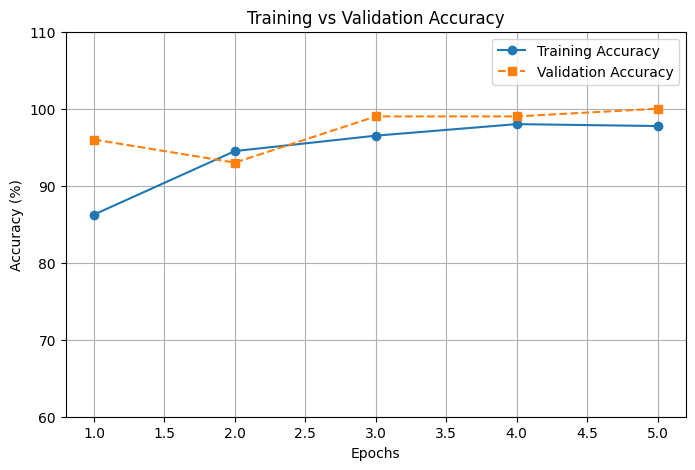

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Training Accuracy", marker="o", linestyle="-")
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy", marker="s", linestyle="--")

plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.ylim(60, 110)

plt.show()

#Save Model

In [ ]:
# Define the path to save the model
model_dir = "/content/drive/MyDrive/511 Project/Models"

# Save the trained model
model_path = os.path.join(model_dir, "crack_detection_model.pth")

torch.save(model.state_dict(), model_path)

print(f"Model saved successfully at: {model_path}")

Model saved successfully at: /content/drive/MyDrive/511 Project/Models/crack_detection_model.pth


# **Checking test images to see if they are identified properly**

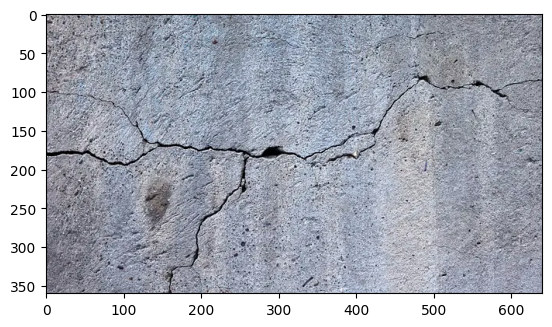

In [ ]:
import cv2
test_crack = Path ("/content/drive/MyDrive/511 Project/datasets/Test/crack1.jpg")

crack_image = Image.open(test_crack).convert("RGB")
im1 = cv2.imread(test_crack)
plt.imshow(im1)

In [ ]:
input_tensor = transform(crack_image).unsqueeze(0).to(device)

with torch.no_grad():
  output = model(input_tensor)  # Forward pass
  prediction = torch.argmax(torch.softmax(output, dim=1), dim=1)

class_names = ["No Crack", "Crack"]  # Replace with your class labels
predicted_class = class_names[prediction.item()]
print(f"Predicted Class: {predicted_class}")

Predicted Class: Crack


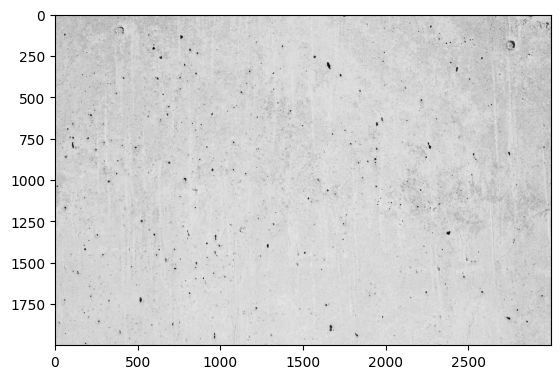

In [ ]:
test_nocrack = Path ("/content/drive/MyDrive/511 Project/datasets/Test/no crack.jpg")

nocrack_image = Image.open(test_nocrack).convert("RGB")
im2 = cv2.imread(test_nocrack)
plt.imshow(im2)

In [ ]:
input_tensor_nocrack = transform(nocrack_image).unsqueeze(0).to(device)

with torch.no_grad():
  output2 = model(input_tensor_nocrack)  # Forward pass
  prediction2 = torch.argmax(torch.softmax(output2, dim=1), dim=1)

class_names = ["No Crack", "Crack"]  # Replace with your class labels
predicted_class2 = class_names[prediction2.item()]
print(f"Predicted Class: {predicted_class2}")

Predicted Class: No Crack


# Testing Model on "Homemade" Dataset

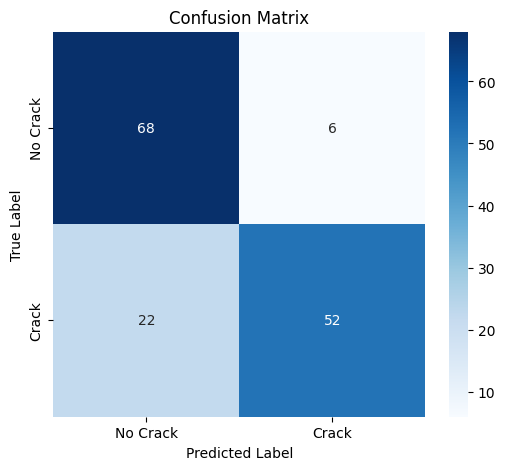

In [ ]:
# Define the transformation (same as used for training)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()  # Set model to evaluation mode

# Define dataset paths
homemade_dataset_path = Path("/content/drive/MyDrive/511 Project/datasets/Homemade")
positive_path = homemade_dataset_path / "Positive"
negative_path = homemade_dataset_path / "Negative"

# Define class labels
class_names = ["No Crack", "Crack"]

# Lists to store true and predicted labels
y_true = []
y_pred = []

# Function to process and predict images
def test_model_on_dataset(dataset_path, label):
    images = os.listdir(dataset_path)

    for img_name in images:
        img_path = dataset_path / img_name
        image = Image.open(img_path).convert("RGB")

        # Apply transformation
        input_tensor = transform(image).unsqueeze(0).to(device)

        # Perform inference
        with torch.no_grad():
            output = model(input_tensor)
            prediction = torch.argmax(torch.softmax(output, dim=1), dim=1)

        # Store true and predicted labels
        y_true.append(label)  # Actual label
        y_pred.append(prediction.item())  # Predicted label

# Test the model on both Positive and Negative datasets
test_model_on_dataset(positive_path, label=1)  # Crack
test_model_on_dataset(negative_path, label=0)  # No Crack

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


# Adding Homemade Data with Augmentations to the Training and Validation Sets

> Add blockquote




In [ ]:


# Define paths
homemade_dataset_path = Path("/content/drive/MyDrive/511 Project/datasets/Homemade")
cracking_dataset_path = Path("/content/drive/MyDrive/511 Project/datasets/cracking")

# Paths for Positive and Negative classes
homemade_positive_path = homemade_dataset_path / "Positive"
homemade_negative_path = homemade_dataset_path / "Negative"
cracking_positive_path = cracking_dataset_path / "Positive"
cracking_negative_path = cracking_dataset_path / "Negative"

# Define augmentation transformations
augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.8),  # Flip 80% of the time
    transforms.RandomVerticalFlip(p=0.5),  # Flip vertically 50% of the time
    transforms.RandomResizedCrop(224, scale=(0.6, 1.0)),  # Reduce resolution to 224x224
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust color properties
    transforms.GaussianBlur(3),  # Apply slight blurring
])

# Function to clear and create folders
def clear_and_create_folder(folder_path):
    if os.path.exists(folder_path):
        shutil.rmtree(folder_path)  # Remove existing folder
    os.makedirs(folder_path)  # Create a new empty folder

# Function to augment images and save in compressed format
def augment_and_save_images(input_folder, output_folder, num_augmentations=7):
    clear_and_create_folder(output_folder)
    if os.path.exists(input_folder):
        image_files = os.listdir(input_folder)
        for img_name in image_files:
            img_path = os.path.join(input_folder, img_name)
            image = Image.open(img_path).convert("L")  # Convert to grayscale
            image = image.resize((128, 128))  # Reduce resolution

            # Save original image in JPEG format with compression
            image.save(os.path.join(output_folder, img_name.replace(".png", ".jpg")), format="JPEG", quality=85)

            for i in range(num_augmentations):
                augmented_image = augmentation_transforms(image)
                augmented_image.save(os.path.join(output_folder, f"aug_{i}_{img_name.replace('.png', '.jpg')}"), format="JPEG", quality=85)

# Apply augmentations ONLY to Homemade dataset
augmented_positive_path = Path("/content/drive/MyDrive/511 Project/datasets/Augmented_Positive")
augmented_negative_path = Path("/content/drive/MyDrive/511 Project/datasets/Augmented_Negative")
augment_and_save_images(homemade_positive_path, augmented_positive_path)
augment_and_save_images(homemade_negative_path, augmented_negative_path)

# Split augmented + cracking dataset into 80% training and 20% validation
def split_dataset(source_folders, train_folder, val_folder, split_ratio=0.8):
    clear_and_create_folder(train_folder)
    clear_and_create_folder(val_folder)

    images = []
    for source_folder in source_folders:
        if os.path.exists(source_folder):
            images.extend([os.path.join(source_folder, img) for img in os.listdir(source_folder)])

    random.seed(42)  # Ensure reproducibility
    random.shuffle(images)
    split_index = int(len(images) * split_ratio)

    for img_path in images[:split_index]:
        shutil.copy(img_path, train_folder)

    for img_path in images[split_index:]:
        shutil.copy(img_path, val_folder)

# Define new dataset paths
train_dataset_path = Path("/content/drive/MyDrive/511 Project/datasets/Training")
val_dataset_path = Path("/content/drive/MyDrive/511 Project/datasets/Validation")

split_dataset([augmented_positive_path, cracking_positive_path], train_dataset_path / "Positive", val_dataset_path / "Positive")
split_dataset([augmented_negative_path, cracking_negative_path], train_dataset_path / "Negative", val_dataset_path / "Negative")

print("Optimized data processing complete! Training set ready!")


Optimized data processing complete! Training set ready!


# Loading Data and Preprocessing

In [ ]:


# Define dataset paths
train_dataset_path = Path("/content/drive/MyDrive/511 Project/datasets/Training")
val_dataset_path = Path("/content/drive/MyDrive/511 Project/datasets/Validation")

# Define transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Keep grayscale
    transforms.Resize((128, 128)),  # Ensure correct size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])  # MobileNet-friendly normalization
])

# Load datasets
train_dataset = datasets.ImageFolder(root=train_dataset_path, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dataset_path, transform=transform)

# Data Loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

#Loading Model (MobileNet V2)

In [ ]:
#Model Selection and Building Using Transfer Learning

# Load pre-trained mobilenet model
model_2 = models.mobilenet_v2(pretrained=True)

# Modify first layer to accept grayscale images (1-channel input)
model_2.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)

# Modify last layer to match binary classification (crack vs. non-crack)
num_ftrs = model_2.classifier[1].in_features
model_2.classifier[1] = nn.Linear(num_ftrs, 2)  # 2 classes: Crack, No Crack

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()

#adding weight decay to prevent over-reliance on particular features
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.001, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)


#Freezing Layers

In [ ]:
# Freeze all layers first
for param in model_2.parameters():
    param.requires_grad = False  # Freeze everything initially

# Freeze ONLY the first 3 convolutional layers
for param in model_2.features[:3].parameters():
    param.requires_grad = False  # Keep first 5 conv layers frozen

# Unfreeze the rest of the convolutional layers (from layer 5 onward)
for param in model_2.features[3:].parameters():
    param.requires_grad = True

# Fully unfreeze the classifier (FC layers)
for param in model_2.classifier.parameters():
    param.requires_grad = True


In [ ]:
summary(model_2, input_size=(1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             288
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

# Model Training and Validation

In [ ]:
from torch.cuda.amp import autocast, GradScaler  # Import for AMP

scaler = GradScaler()  # Mixed precision scaling

train_accuracies = []
val_accuracies = []

num_epochs = 5
for epoch in range(num_epochs):
    model_2.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with autocast():  # Enables mixed precision training
            outputs = model_2(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_acc = 100 * correct / total  # Training Accuracy
    train_accuracies.append(train_acc)

    # Validation Accuracy Calculation
    model_2.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_2(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_acc = 100 * correct / total  # Validation Accuracy
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Training Acc: {train_acc:.2f}%, Validation Acc: {val_acc:.2f}%")

    scheduler.step()  # Update learning rate


<ipython-input-9-18d7512a2ab2>:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # Mixed precision scaling
<ipython-input-9-18d7512a2ab2>:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Enables mixed precision training
/usr/local/lib/python3.11/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 1/5, Loss: 0.3011, Training Acc: 90.56%, Validation Acc: 98.52%
Epoch 2/5, Loss: 0.1595, Training Acc: 94.21%, Validation Acc: 97.93%
Epoch 3/5, Loss: 0.1368, Training Acc: 95.17%, Validation Acc: 97.04%
Epoch 4/5, Loss: 0.0756, Training Acc: 97.70%, Validation Acc: 98.82%
Epoch 5/5, Loss: 0.0937, Training Acc: 98.74%, Validation Acc: 98.82%


#Plotting

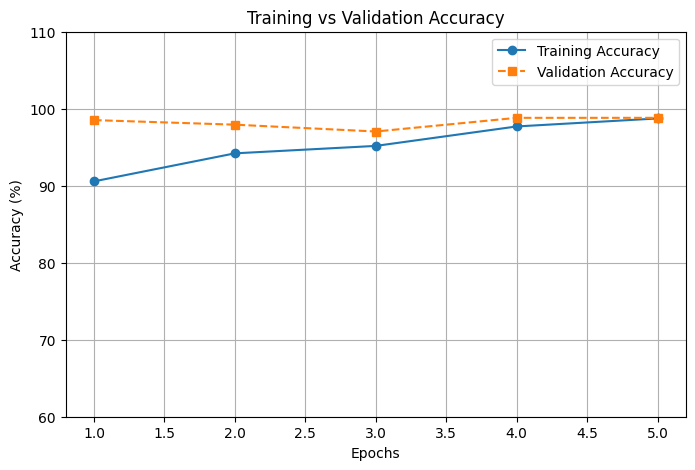

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Training Accuracy", marker="o", linestyle="-")
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy", marker="s", linestyle="--")

plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.ylim(60, 110)

plt.show()

#Saving Model

In [ ]:
# Define the path to save the model
model_dir = "/content/drive/MyDrive/511 Project/Models"

# Save the trained model
model_path = os.path.join(model_dir, "crack_detection_model_mobilenet.pth")

torch.save(model_2.state_dict(), model_path)

print(f"Model saved successfully at: {model_path}")

Model saved successfully at: /content/drive/MyDrive/511 Project/Models/crack_detection_model_mobilenet.pth


#Testing Model on Homemade Dataset

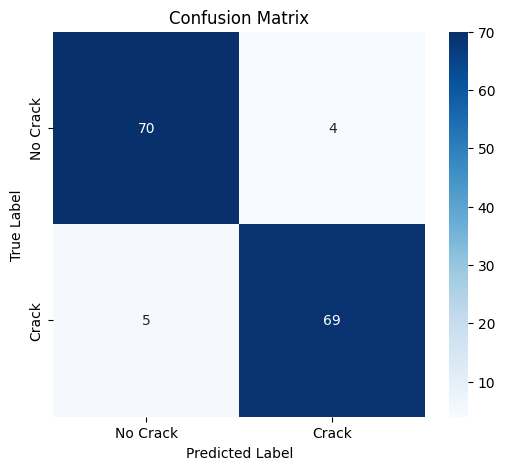

In [ ]:
# Define the transformation (same as used for training)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_2.eval()  # Set model to evaluation mode

# Define dataset paths
homemade_dataset_path = Path("/content/drive/MyDrive/511 Project/datasets/Homemade")
positive_path = homemade_dataset_path / "Positive"
negative_path = homemade_dataset_path / "Negative"

# Define class labels
class_names = ["No Crack", "Crack"]

# Lists to store true and predicted labels
y_true = []
y_pred = []

# Function to process and predict images
def test_model_on_dataset(dataset_path, label):
    images = os.listdir(dataset_path)

    for img_name in images:
        img_path = dataset_path / img_name
        image = Image.open(img_path).convert("RGB")

        # Apply transformation
        input_tensor = transform(image).unsqueeze(0).to(device)

        # Perform inference
        with torch.no_grad():
            output = model_2(input_tensor)
            prediction = torch.argmax(torch.softmax(output, dim=1), dim=1)

        # Store true and predicted labels
        y_true.append(label)  # Actual label
        y_pred.append(prediction.item())  # Predicted label

# Test the model on both Positive and Negative datasets
test_model_on_dataset(positive_path, label=1)  # Crack
test_model_on_dataset(negative_path, label=0)  # No Crack

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


# Model Compression for IOT

In [ ]:
# Load MobileNetV2
model = models.mobilenet_v2()
model.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)

# Load trained weights
model.load_state_dict(torch.load('/content/drive/MyDrive/511 Project/Models/crack_detection_model_mobilenet.pth'))
model.eval()


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

#Define Pruning Function

In [ ]:

def iterative_prune(model, train_loader, val_loader, num_iterations=5, prune_amount=0.2, epochs_per_iteration=1, device='cuda'):

    model = copy.deepcopy(model).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    sparsity_history = []

    for i in range(num_iterations):
        print(f"--- Iteration {i+1}/{num_iterations} ---")

        # Step 1: Prune a portion of weights
        for name, module in model.named_modules():
            if isinstance(module, (nn.Conv2d, nn.Linear)):
                prune.l1_unstructured(module, name='weight', amount=prune_amount)

        # Step 2: Fine-tune
        model.train()
        for epoch in range(epochs_per_iteration):
            for x, y in train_loader:
                x, y = x.to(device), y.to(device)
                optimizer.zero_grad()
                outputs = model(x)
                loss = criterion(outputs, y)
                loss.backward()
                optimizer.step()

        # Step 3: Evaluate
        acc = evaluate(model, val_loader, device)
        size = get_model_size(model)
        print(f"Accuracy after iteration {i+1}: {acc:.2f}% | Model size: {size:.2f} MB")
        sparsity = measure_global_sparsity(model)
        sparsity_history.append((i+1, acc, sparsity))

    # Strip pruning wrappers
    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            prune.remove(module, 'weight')

    return model, sparsity_history



#Function for measuring sparsity

In [ ]:
def measure_global_sparsity(model):
    total = 0
    zero = 0
    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            tensor = module.weight.data.cpu().numpy()
            total += tensor.size
            zero += (tensor == 0).sum()
    return 100.0 * zero / total


#Function for Evaluating Model

In [ ]:
def evaluate(model, dataloader, device):
    model.to(device)
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            _, predicted = outputs.max(1)
            correct += predicted.eq(y).sum().item()
            total += y.size(0)
    return correct / total * 100

def get_model_size(model, path='temp.pth'):
    torch.save(model.state_dict(), path)
    size = os.path.getsize(path) / 1e6  # MB
    os.remove(path)
    return size

#Run pruning

In [ ]:
pruned_model, history = iterative_prune(
    model, train_loader, val_loader,
    num_iterations=5,
    prune_amount=0.2,
    epochs_per_iteration=2,
    device='cpu'
)


--- Iteration 1/5 ---
Accuracy after iteration 1: 98.82% | Model size: 17.91 MB
--- Iteration 2/5 ---
Accuracy after iteration 2: 98.82% | Model size: 17.91 MB
--- Iteration 3/5 ---
Accuracy after iteration 3: 98.52% | Model size: 17.91 MB
--- Iteration 4/5 ---
Accuracy after iteration 4: 97.93% | Model size: 17.91 MB
--- Iteration 5/5 ---
Accuracy after iteration 5: 97.93% | Model size: 17.91 MB


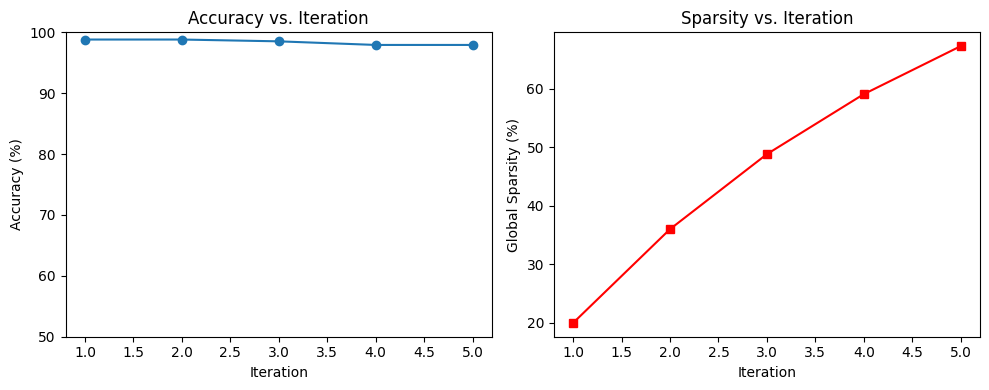

In [ ]:
iterations, accuracies, sparsities = zip(*history)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(iterations, accuracies, marker='o')
plt.title("Accuracy vs. Iteration")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.ylim(50,100)

plt.subplot(1, 2, 2)
plt.plot(iterations, sparsities, marker='s', color='red')
plt.title("Sparsity vs. Iteration")
plt.xlabel("Iteration")
plt.ylabel("Global Sparsity (%)")

plt.tight_layout()
plt.show()


#Saving Pruned Model

In [ ]:
# Define the path to save the model
model_dir = "/content/drive/MyDrive/511 Project/Models"

# Save the trained model
model_path = os.path.join(model_dir, "crack_detection_model_mobilenet_pruned.pth")

torch.save(pruned_model.state_dict(), model_path)

print(f"Model saved successfully at: {model_path}")

Model saved successfully at: /content/drive/MyDrive/511 Project/Models/crack_detection_model_mobilenet_pruned.pth


#Sparsity Histogram

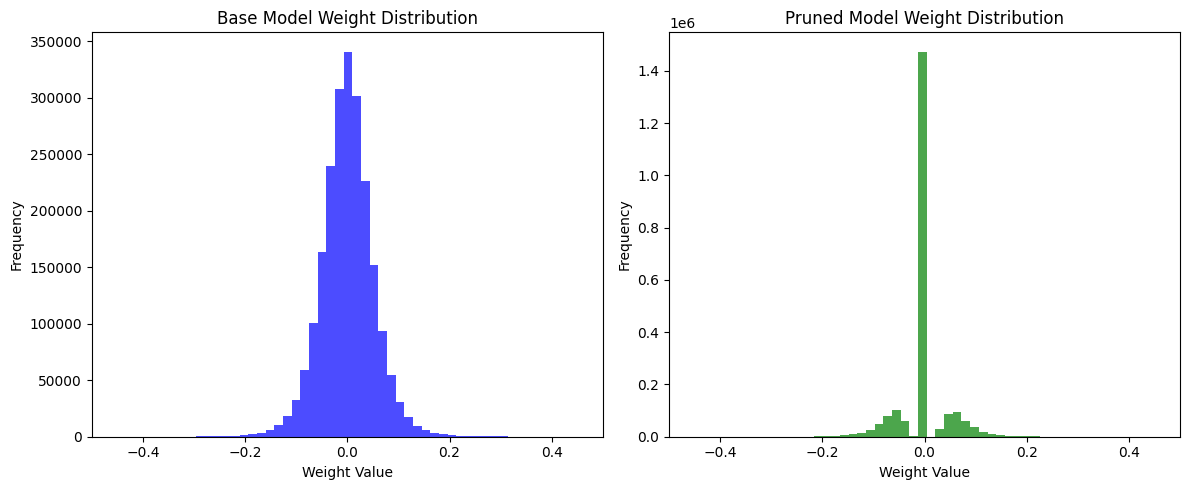

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to load MobileNetV2 model
def load_mobilenet_model(path):
    model = models.mobilenet_v2()
    model.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)
    model.load_state_dict(torch.load(path, map_location=device))
    model.eval()
    return model.to(device)

# Paths to models
base_model_path = "/content/drive/MyDrive/511 Project/Models/crack_detection_model_mobilenet.pth"
pruned_model_path = "/content/drive/MyDrive/511 Project/Models/crack_detection_model_mobilenet_pruned.pth"

# Load models
crack_detection_model_mobilenet = load_mobilenet_model(base_model_path)
crack_detection_model_mobilenet_pruned = load_mobilenet_model(pruned_model_path)

# Extract weight values
def get_weight_distribution(model):
    all_weights = []
    for module in model.modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            weight_tensor = module.weight.data.cpu().numpy().flatten()
            all_weights.extend(weight_tensor)
    return all_weights

base_weights = get_weight_distribution(crack_detection_model_mobilenet)
pruned_weights = get_weight_distribution(crack_detection_model_mobilenet_pruned)

# Plot histograms
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(base_weights, bins=300, color='blue', alpha=0.7)
plt.title("Base Model Weight Distribution")
plt.xlabel("Weight Value")
plt.ylabel("Frequency")
plt.xlim(-.5,.5)

plt.subplot(1, 2, 2)
plt.hist(pruned_weights, bins=300, color='green', alpha=0.7)
plt.title("Pruned Model Weight Distribution")
plt.xlabel("Weight Value")
plt.ylabel("Frequency")
plt.xlim(-.5,.5)

plt.tight_layout()
plt.show()


#stripping pruned model for efficient storage

In [ ]:
# Load pruned MobileNetV2 model and strip pruning for efficient storage
import torch.nn.utils.prune as prune

def load_and_strip_pruned_mobilenet(path, device='cpu'):
    # Load MobileNetV2 architecture
    model = models.mobilenet_v2()
    model.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)

    # Load pruned weights
    model.load_state_dict(torch.load(path, map_location=device))

    # Strip pruning wrappers if any remain
    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)) and hasattr(module, 'weight_orig'):
            prune.remove(module, 'weight')

    return model.to(device).eval()

# Example usage
stripped_model = load_and_strip_pruned_mobilenet(
    "/content/drive/MyDrive/511 Project/Models/crack_detection_model_mobilenet_pruned.pth",
    device='cuda' if torch.cuda.is_available() else 'cpu'
)


In [ ]:
# Define the path to save the model
model_dir = "/content/drive/MyDrive/511 Project/Models"

# Save the stripped model
model_path = os.path.join(model_dir, "crack_detection_model_mobilenet_pruned_stripped.pth")

torch.save(stripped_model.state_dict(), model_path)

print(f"Model saved successfully at: {model_path}")

Model saved successfully at: /content/drive/MyDrive/511 Project/Models/crack_detection_model_mobilenet_pruned_stripped.pth


📦 Base MobileNetV2 size:     9.14 MB
📉 Stripped Pruned Model size: 9.14 MB


#Post-Training Static Quantization

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === 1. Load Pruned MobileNetV2 === #
def load_pruned_mobilenet(path):
    model = models.mobilenet_v2()
    model.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)
    model.load_state_dict(torch.load(path, map_location=device))
    return model.eval()

pruned_model_path = "/content/drive/MyDrive/511 Project/Models/crack_detection_model_mobilenet_pruned.pth"
model_fp32 = load_pruned_mobilenet(pruned_model_path)

# === 2. Prepare Calibration Dataset === #
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

val_data_path = Path("/content/drive/MyDrive/511 Project/datasets/Validation")
val_dataset = ImageFolder(root=val_data_path, transform=transform)
calibration_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# === 3. Fuse layers (only the first block here as an example) === #
# You can fuse more MobileNet blocks if needed
model_fp32_fused = model_fp32
model_fp32_fused.eval()

# === 4. Attach QConfig === #
model_fp32_fused.qconfig = get_default_qconfig('fbgemm')  # Best for x86 CPUs

# === 5. Prepare for static quantization === #
prepare(model_fp32_fused, inplace=True)

# === 6. Calibrate === #
with torch.no_grad():
    for inputs, _ in calibration_loader:
        model_fp32_fused(inputs)

# === 7. Convert to quantized model === #
quantized_model = convert(model_fp32_fused, inplace=False)

# === 8. Save Quantized Model === #
quantized_model_path = "/content/drive/MyDrive/511 Project/Models/crack_detection_model_mobilenet_pruned_quantized.pth"
torch.save(quantized_model.state_dict(), quantized_model_path)
print(f"Quantized model saved at: {quantized_model_path}")

/usr/local/lib/python3.11/dist-packages/torch/ao/quantization/observer.py:229: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


Quantized model saved at: /content/drive/MyDrive/511 Project/Models/crack_detection_model_mobilenet_pruned_quantized.pth


#Summary Of All Models

## NOTE:
### We applied post-training static quantization above to compress the model and make it efficient for edge devices.
### However, due to Colab's environment not supporting 'quantized::conv2d' execution, we use dynamic quantization below for evaluation purposes only. This still reduces model size and speeds up inference on linear layers.

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# =======================
# DataLoader Setup
# =======================
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

val_dataset = datasets.ImageFolder(
    root="/content/drive/MyDrive/511 Project/datasets/Validation",
    transform=transform
)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# =======================
# Utility Functions
# =======================

def evaluate(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    start_time = time.time()
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            _, predicted = outputs.max(1)
            correct += predicted.eq(y).sum().item()
            total += y.size(0)
    end_time = time.time()
    acc = 100 * correct / total
    avg_time = (end_time - start_time) / total
    return acc, avg_time

def get_model_size(path):
    return os.path.getsize(path) / 1e6  # MB

def load_resnet(path):
    model = models.resnet18()
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(nn.Dropout(0.5), nn.Linear(num_ftrs, 2))
    model.load_state_dict(torch.load(path, map_location=device))
    return model.to(device).eval()

def load_mobilenet(path):
    model = models.mobilenet_v2()
    model.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)
    model.load_state_dict(torch.load(path, map_location=device))
    return model.to(device).eval()

# ✅ Define your quantized model loader
def load_dynamically_quantized_mobilenet(path):
    model = models.mobilenet_v2()
    model.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)

    # Load weights BEFORE quantization
    model.load_state_dict(torch.load(path, map_location='cpu'))
    model.eval()

    # Apply dynamic quantization
    quantized_model = torch.quantization.quantize_dynamic(
        model, {nn.Linear}, dtype=torch.qint8
    )
    return quantized_model


def test_model(name, path, load_fn):
    model = load_fn(path)
    acc, inf_time = evaluate(model, val_loader)
    size = get_model_size(path)
    del model
    torch.cuda.empty_cache()
    gc.collect()
    return {
        "Model": name,
        "Validation Accuracy (%)": acc,
        "Avg Inference Time (s/image)": inf_time,
        "Model Size (MB)": size
    }

# =======================
# Run Comparison
# =======================
base_path = "/content/drive/MyDrive/511 Project/Models"
models_info = [
    ("ResNet18", "crack_detection_model.pth", load_resnet),
    ("MobileNetV2", "crack_detection_model_mobilenet.pth", load_mobilenet),
    ("Pruned MobileNetV2", "crack_detection_model_mobilenet_pruned.pth", load_mobilenet),
    ("Dynamically Quantized MobileNetV2", "crack_detection_model_mobilenet_pruned.pth", load_dynamically_quantized_mobilenet)
]

results = []
for name, filename, loader in models_info:
    full_path = os.path.join(base_path, filename)
    results.append(test_model(name, full_path, loader))

# Display results
df = pd.DataFrame(results)
print(df)


                               Model  Validation Accuracy (%)  \
0                           ResNet18                91.715976   
1                        MobileNetV2                94.970414   
2                 Pruned MobileNetV2                90.236686   
3  Dynamically Quantized MobileNetV2                90.236686   

   Avg Inference Time (s/image)  Model Size (MB)  
0                      0.091058        44.764002  
1                      0.079231         9.151054  
2                      0.080725         9.153344  
3                      0.082273         9.153344  


In [ ]:


# Set to CPU for consistency and compatibility with quantized ops
device = torch.device("cpu")

# Dummy input (batch size 8 to lower memory use)
input_tensor = torch.randn(8, 1, 224, 224).to(device)

# Benchmark function
def benchmark_model(model, input_tensor, iterations=50):
    model.eval()
    times = []

    # Warm-up
    with torch.no_grad():
        for _ in range(5):
            _ = model(input_tensor)

        for _ in range(iterations):
            start = time.time()
            _ = model(input_tensor)
            end = time.time()
            times.append(end - start)

    avg_time = np.mean(times) / input_tensor.size(0)
    std_time = np.std(times) / input_tensor.size(0)
    return avg_time, std_time

# Model loading functions
def load_resnet(path):
    model = models.resnet18()
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model.fc = nn.Sequential(nn.Dropout(0.5), nn.Linear(model.fc.in_features, 2))
    model.load_state_dict(torch.load(path, map_location=device))
    return model.to(device).eval()

def load_mobilenet(path):
    model = models.mobilenet_v2()
    model.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)
    model.load_state_dict(torch.load(path, map_location=device))
    return model.to(device).eval()

def load_dynamic_mobilenet(path):
    model = load_mobilenet(path)
    return torch.quantization.quantize_dynamic(model, {nn.Linear}, dtype=torch.qint8)

def load_dynamic_resnet(path):
    model = load_resnet(path)
    return torch.quantization.quantize_dynamic(model, {nn.Linear}, dtype=torch.qint8)

# Define model info
base_path = "/content/drive/MyDrive/511 Project/Models"
models_to_test = [
    ("ResNet18", os.path.join(base_path, "crack_detection_model.pth"), load_resnet),
    ("MobileNetV2", os.path.join(base_path, "crack_detection_model_mobilenet.pth"), load_mobilenet),
    ("Pruned MobileNetV2", os.path.join(base_path, "crack_detection_model_mobilenet_pruned.pth"), load_mobilenet),
    ("Dynamic Quantized MobileNetV2", os.path.join(base_path, "crack_detection_model_mobilenet_pruned.pth"), load_dynamic_mobilenet),
    ("Dynamic Quantized ResNet18", os.path.join(base_path, "crack_detection_model.pth"), load_dynamic_resnet)
]

# Run and collect results
results = []
for name, path, loader in models_to_test:
    print(f"⏱️ Benchmarking: {name}")
    model = loader(path)
    avg, std = benchmark_model(model, input_tensor)
    results.append({
        "Model": name,
        "Avg Inference Time (s/image)": avg,
        "Std Dev (s/image)": std
    })
    del model
    gc.collect()
    torch.cuda.empty_cache()

# Display results
df = pd.DataFrame(results)
print(df)


⏱️ Benchmarking: ResNet18
⏱️ Benchmarking: MobileNetV2
⏱️ Benchmarking: Pruned MobileNetV2
⏱️ Benchmarking: Dynamic Quantized MobileNetV2
⏱️ Benchmarking: Dynamic Quantized ResNet18
                           Model  Avg Inference Time (s/image)  \
0                       ResNet18                      0.080376   
1                    MobileNetV2                      0.047388   
2             Pruned MobileNetV2                      0.043663   
3  Dynamic Quantized MobileNetV2                      0.046861   
4     Dynamic Quantized ResNet18                      0.077028   

   Std Dev (s/image)  
0           0.016687  
1           0.008082  
2           0.006835  
3           0.008392  
4           0.015089  


In [ ]:
df

,Model,Avg Inference Time (s/image),Std Dev (s/image)
0,ResNet18,0.080376,0.016687
1,MobileNetV2,0.047388,0.008082
2,Pruned MobileNetV2,0.043663,0.006835
3,Dynamic Quantized MobileNetV2,0.046861,0.008392
4,Dynamic Quantized ResNet18,0.077028,0.015089


#pca